# Air System Failure Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, recall_score, precision_score, confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.9.1
pandas    : 2.2.2
numpy     : 2.0.0



Versions used on this project

## Loading Data

In [3]:
prev_years = pd.read_csv('data/air_system_previous_years.csv', na_values=['na'])
prev_years.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [4]:
prev_years.shape

(60000, 171)

In [5]:
prev_years['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

## Splitting in train/test data already

In [6]:
# We will be splitting the data into 80% of train data and 20% of test data. We are using random state. Lately we will use a k-fold validation anyways. 
train, test = train_test_split(prev_years, test_size=.2)

## Checking for missing values

In [7]:
missing_values = train.isna().sum()
missing_values

class         0
aa_000        0
ab_000    37081
ac_000     2714
ad_000    11841
          ...  
ee_007      530
ee_008      530
ee_009      530
ef_000     2220
eg_000     2219
Length: 171, dtype: int64

Our target columns doesn't have any missing value

In [8]:
missing_values_percentage = missing_values*100 / len(train)
missing_values_percentage.sort_values(ascending=False)[:20]

br_000    82.072917
bq_000    81.164583
bp_000    79.525000
cr_000    77.252083
ab_000    77.252083
bo_000    77.208333
bn_000    73.241667
bm_000    65.818750
bl_000    45.437500
bk_000    38.370833
ad_000    24.668750
cg_000    24.668750
ch_000    24.668750
cf_000    24.668750
co_000    24.668750
cx_000    22.916667
cz_000    22.916667
cy_000    22.916667
dc_000    22.916667
db_000    22.916667
dtype: float64

In [9]:
# Amount of columns with a missing value
sum(missing_values != 0)

169

Almost all columns have a missing value

In [10]:
# Amount of rows with at least a missing value
sum(train.isna().sum(axis=1) != 0)

47521

Apparently we will need to automate the data cleaning process due to the large amount of columns with missing values

In [11]:
del missing_values
del missing_values_percentage

# Data preparation

### Data balancing (not used anymore)

In [12]:
# difference = len(train[train['class'] == 'neg']) - len(train[train['class'] == 'pos'])
# neg_indices_to_drop = np.random.choice(train[train['class'] == 'neg'].index, size=difference, replace=False)

# del difference

In [13]:
# train = train.drop(index=neg_indices_to_drop)

### Getting the features and the target

In [14]:
X_train, y_train = train.drop(columns=['class']), train['class']

### Creating the pipeline for preparing the data and reduce dimensionality

In [15]:
class ColumnSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)

In [16]:
# Dropping any column that has more than 50% of it's values missing
columns_to_drop = X_train.columns[X_train.isna().sum()/len(X_train) > .5]

In [17]:
# This pipeline will clean and scale our X train data.
transformer_pipeline = Pipeline([
    ('column_selector', ColumnSelection(columns_to_drop)),
    ('median_imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

transformer_pipeline.fit(X_train)

Pipeline(steps=[('column_selector',
                 ColumnSelection(columns=Index(['ab_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000',
       'cr_000'],
      dtype='object'))),
                ('median_imputer', SimpleImputer(strategy='median')),
                ('standard_scaler', StandardScaler()),
                ('pca', PCA(n_components=5))])

In [18]:
def preprocess_data(x, y, transformer_pipeline):
    '''Function that preprocess the features and the label data to automate the process'''
    x_preprocessed = transformer_pipeline.transform(x)
    y_preprocessed = np.where(y == 'neg', 0, 1)

    return x_preprocessed, y_preprocessed

In [19]:
# The name of remaining columns. (Necessary because x_preprocessed is a numpy array, i.e doesnt't have column names)
left_columns = X_train.drop(columns=columns_to_drop).columns

In [20]:
X_train_components, y_train = preprocess_data(X_train, y_train, transformer_pipeline)

In [21]:
X_train_components[:5, :5]

array([[-0.6653571 ,  0.07955599,  0.29587659, -0.0577144 , -0.31235094],
       [ 3.39445536,  0.76746979,  2.28176578,  0.42368191, -0.7358793 ],
       [-3.0581117 ,  0.22960799, -0.70671815,  0.29805174,  0.16092969],
       [-3.14820977,  0.22965392, -0.75660508,  0.28574938,  0.21059249],
       [-2.98272142,  0.06168039, -0.85874081,  0.36963655,  0.05370963]])

Our train data features are already cleaned and scaled. The next step is to apply a dimensionality reduction algorithm so we can work with less columns and extract the feature importances.

## Analysis of the components

In [22]:
X_train_components

array([[-0.6653571 ,  0.07955599,  0.29587659, -0.0577144 , -0.31235094],
       [ 3.39445536,  0.76746979,  2.28176578,  0.42368191, -0.7358793 ],
       [-3.0581117 ,  0.22960799, -0.70671815,  0.29805174,  0.16092969],
       ...,
       [-1.41377117,  0.50165969, -0.56168662,  0.13713496,  0.0601975 ],
       [-3.09967077,  0.10950032, -0.74615849,  0.24357446,  0.16412098],
       [-3.11170819,  0.10251667, -0.75383436,  0.24347726,  0.1712678 ]])

In [23]:
X_train_components.shape

(48000, 5)

In [24]:
pca = transformer_pipeline.named_steps['pca']
pca.explained_variance_

array([48.29157438,  8.00404905,  6.32812108,  5.00859504,  4.18079694])

In [25]:
most_important_index = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]

In [26]:
most_important_columns = left_columns[most_important_index]
most_important_columns

Index(['bx_000', 'cx_000', 'dt_000', 'ag_008', 'bj_000'], dtype='object')

In [27]:
for i in range(pca.n_components_):
    print(f"{most_important_columns[i]}: {pca.components_[i][most_important_index[i]]}")

bx_000: 0.1352027709172466
cx_000: 0.18864886919947305
dt_000: 0.22049625799874173
ag_008: 0.2687983003463807
bj_000: 0.2349812330819312


These are the most influent features for each principal component.

The first component explains almost 50% of the variation on the dataset, the second component explains 8% and so on.

## Machine Learning model building using Classification Algorithm

In [28]:
def evaluate_model(model, x=X_train_components, y=y_train):
    for i in ['recall', 'precision', 'accuracy']:
        skf = StratifiedKFold(n_splits=5)
        scores = cross_val_score(model, x, y, cv=skf, scoring=i)
        mean = scores.mean()
        std = scores.std()
        print("METRIC: {}\nSCORES: {}\nMEAN: {:.4f}\nSTD: {:.4f}\n".format(i, scores, mean, std))

In [29]:
def plot_roc_curve(models_dict, x=X_train_components, y=y_train):
    for model_name in models_dict:
        y_scores = cross_val_predict(models_dict[model_name], X_train_components, y_train, method='predict_proba')[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, y_scores)
        plt.plot(fpr, tpr, label=model_name)

    plt.plot(fpr, fpr, label="random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")
    plt.legend()
    plt.show()

In [31]:
# Benchmark Classifiers
dt_benchmark = DecisionTreeClassifier()
rf_benchmark = RandomForestClassifier()
log_benchmark = LogisticRegression()

In [32]:
evaluate_model(dt_benchmark, X_train_components, y_train)

METRIC: recall
SCORES: [0.55900621 0.52173913 0.50931677 0.51851852 0.5308642 ]
MEAN: 0.5279
STD: 0.0170

METRIC: precision
SCORES: [0.53216374 0.51592357 0.5408805  0.5        0.51807229]
MEAN: 0.5214
STD: 0.0141

METRIC: accuracy
SCORES: [0.98479167 0.98385417 0.98395833 0.98364583 0.98385417]
MEAN: 0.9840
STD: 0.0004



In [33]:
evaluate_model(log_benchmark)

METRIC: recall
SCORES: [0.32919255 0.28571429 0.27329193 0.25925926 0.2962963 ]
MEAN: 0.2888
STD: 0.0237

METRIC: precision
SCORES: [0.6091954  0.52873563 0.55696203 0.53846154 0.49484536]
MEAN: 0.5456
STD: 0.0376

METRIC: accuracy
SCORES: [0.98520833 0.98375    0.98416667 0.98375    0.98302083]
MEAN: 0.9840
STD: 0.0007



In [33]:
evaluate_model(rf_benchmark)

METRIC: recall
SCORES: [0.51282051 0.50641026 0.52229299 0.53503185 0.46496815]
MEAN: 0.5083
STD: 0.0237

METRIC: precision
SCORES: [0.73584906 0.7027027  0.75454545 0.75       0.73267327]
MEAN: 0.7352
STD: 0.0182

METRIC: accuracy
SCORES: [0.98927083 0.98875    0.98927083 0.98958333 0.98885417]
MEAN: 0.9891
STD: 0.0003



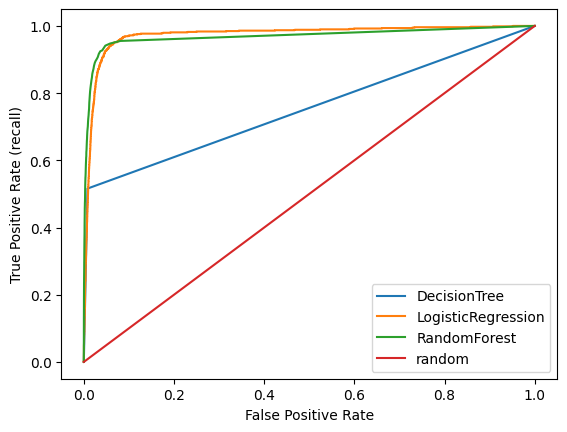

In [34]:
models_dict = {
    "DecisionTree": dt_benchmark,
    "LogisticRegression": log_benchmark,
    "RandomForest": rf_benchmark,
}
plot_roc_curve(models_dict)

Here we can see that RandomForest and LogisticRegression have the higher AUC. That means that if we want to raise the recall of our model, the fall rate of precision is low.

In [35]:
for model_name in models_dict:
    y_score = cross_val_predict(models_dict[model_name], X_train_components, y_train, method='predict_proba')[:, 1]
    auc = roc_auc_score(y_train, y_score)
    print("==============")
    print("{}\nAUC: {:.4f}\n".format(model_name, auc))

DecisionTree
AUC: 0.7552

LogisticRegression
AUC: 0.9739

RandomForest
AUC: 0.9702



## Hyperparameter Optimization

The model chosen to be tunned was the DecisionTreeClassifier due to his recall score close to the RandomForest and it's way less complexity and has a better hardware performance.

In [36]:
# rf_v1 = RandomForestClassifier(random_state=42)
dt_v1 = DecisionTreeClassifier(random_state=42)

In [37]:
param_grid = {
    # "n_estimators": [50, 100],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [20, 50, 150, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 4, 10],
    'class_weight': ['balanced']
}

In [38]:
random_search = RandomizedSearchCV(dt_v1, param_grid, scoring="recall")
random_search.fit(X_train_components, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [20, 50, 150, None],
                                        'min_samples_leaf': [1, 4, 10],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='recall')

In [39]:
random_search.best_score_

np.float64(0.7995590396864282)

In [40]:
random_search.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_depth': 150,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [41]:
grid_search = GridSearchCV(dt_v1, param_grid, scoring="recall")
grid_search.fit(X_train_components, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [20, 50, 150, None],
                         'min_samples_leaf': [1, 4, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [42]:
grid_search.best_score_

np.float64(0.7995590396864282)

In [43]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [44]:
param_grid_2 = {
    # "n_estimators": [20, 50, 70],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 10],
    'class_weight': ['balanced']
}

In [45]:
random_search_2 = RandomizedSearchCV(dt_v1, param_grid_2, scoring="recall")
random_search_2.fit(X_train_components, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [5, 10, 20, None],
                                        'min_samples_leaf': [2, 4, 10],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='recall')

In [46]:
random_search_2.best_score_

np.float64(0.925926833251674)

In [47]:
random_search_2.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'class_weight': 'balanced'}

In [48]:
grid_search_2 = GridSearchCV(dt_v1, param_grid_2, scoring="recall")
grid_search_2.fit(X_train_components, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [2, 4, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [49]:
grid_search_2.best_score_

np.float64(0.925926833251674)

In [50]:
grid_search_2.best_params_

{'class_weight': 'balanced',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

## Final model building

In [34]:
best_params = {'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'class_weight': 'balanced'}

In [35]:
# model = RandomForestClassifier(**best_params, random_state=42)
model = DecisionTreeClassifier(**best_params)

In [36]:
model.fit(X_train_components, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

In [37]:
y_preds = model.predict(X_train_components)

In [38]:
recall_score(y_train, y_preds)

np.float64(0.9752168525402726)

In [39]:
precision_score(y_train, y_preds)

np.float64(0.24509498598567425)

In [40]:
confusion_matrix(y_train, y_preds)

array([[44769,  2424],
       [   20,   787]])

As you can see, we opted to have a high recall score instead a high precision due to the cost of the false negatives. The model predicts more positives cases on the dataset because the false positives only costs $10 if it gets the prediction wrong.

## Business testing using the model

In [41]:
def model_report(y_true, y_pred, y_benchmark=None):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    tp = ((y_pred == 1) & (y_true == 1)).sum()


    total_cost = fp*10 + fn*500 + tp*25
    unecessary_cost = total_cost - tp*25
    money_saved = (y_true == 1).sum()*500 - unecessary_cost

    if y_benchmark is not None:
        recall_benchmark = recall_score(y_true, y_benchmark)
        precision_benchmark = precision_score(y_true, y_benchmark)
        
        fp_benchmark = ((y_benchmark == 1) & (y_true == 0)).sum()
        fn_benchmark = ((y_benchmark == 0) & (y_true == 1)).sum()
        tp_benchmark = ((y_benchmark == 1) & (y_true == 1)).sum()

        total_cost_benchmark = fp_benchmark*10 + fn_benchmark*500 + tp_benchmark*25
        unecessary_cost_benchmark = total_cost_benchmark - tp_benchmark*25
        money_saved_benchmark = (y_true == 1).sum()*500 - unecessary_cost_benchmark

    print("====================")
    print("MODEL REPORT")
    print("Recall score: {:.4f}\nPrecision score: {:.4f}\n".format(recall, precision))
    print("Total cost spent: ${}\nUnecessary Cost (model error): ${}\nMoney Saved With the Model: ${}".format(total_cost, unecessary_cost, money_saved))
    if y_benchmark is not None:
        print("--------------------")
        print("BENCHMARK")
        print("Recall score: {:.4f}\nPrecision score: {:.4f}\n".format(recall_benchmark, precision_benchmark))
        print("Total cost spent: ${}\nUnecessary Cost (model error): ${}\nMoney Saved With the Model: ${}".format(total_cost_benchmark, unecessary_cost_benchmark, money_saved_benchmark))
    print("====================")

In [42]:
X_test, y_test = test.drop(columns=['class']), test['class']
X_test_components, y_test = preprocess_data(X_test, y_test, transformer_pipeline)

In [43]:
y_pred = model.predict(X_test_components)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
dt_benchmark.fit(X_train_components, y_train)

y_bench = dt_benchmark.predict(X_test_components)

In [45]:
model_report(y_test, y_pred, y_bench)

MODEL REPORT
Recall score: 0.9119
Precision score: 0.2362

Total cost spent: $18590
Unecessary Cost (model error): $14190
Money Saved With the Model: $82310
--------------------
BENCHMARK
Recall score: 0.4870
Precision score: 0.5562

Total cost spent: $52600
Unecessary Cost (model error): $50250
Money Saved With the Model: $46250


## Completed Model trained on the whole dataset

In [46]:
X_data, y_data = prev_years.drop(columns='class'), prev_years['class']

X_preprocessed, y_preprocessed = preprocess_data(X_data, y_data, transformer_pipeline)

In [47]:
model = DecisionTreeClassifier(**best_params)
model

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

In [48]:
evaluate_model(model, X_preprocessed, y_preprocessed)

METRIC: recall
SCORES: [0.935 0.965 0.905 0.95  0.945]
MEAN: 0.9400
STD: 0.0200

METRIC: precision
SCORES: [0.2122588  0.2118551  0.22484472 0.21276596 0.24137931]
MEAN: 0.2206
STD: 0.0115

METRIC: accuracy
SCORES: [0.94108333 0.93958333 0.9465     0.94058333 0.94958333]
MEAN: 0.9435
STD: 0.0039



In [49]:
model.fit(X_preprocessed, y_preprocessed)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

## Model persistence

In [50]:
with open('models/model_v1.pickle', 'wb') as file:
    pickle.dump(model, file)

with open('models/transformer_pipeline.pickle', 'wb') as file:
    pickle.dump(transformer_pipeline, file)

## Test on present year

In [51]:
pres_year = pd.read_csv('data/air_system_present_year.csv', na_values=['na'])

new_features, classes = pres_year.drop(columns='class'), pres_year['class']

new_features_preprocessed, classes_preprocessed = preprocess_data(new_features, classes, transformer_pipeline)

In [52]:
classes_preds = model.predict(new_features_preprocessed)

recall_score(classes_preprocessed, classes_preds)

np.float64(0.9573333333333334)

In [53]:
model_report(classes_preprocessed, classes_preds)

MODEL REPORT
Recall score: 0.9573
Precision score: 0.3122

Total cost spent: $24885
Unecessary Cost (model error): $15910
Money Saved With the Model: $171590


Our model saved us **$171.590,00**!